In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
ano_dir = 'drive/MyDrive/face-mask-detection/annotations'
img_dir = 'drive/MyDrive/face-mask-detection/images'

In [5]:
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [6]:
imgs = list(sorted(os.listdir(img_dir)))

In [7]:
labels = list(sorted(os.listdir(ano_dir)))

In [8]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(img_dir)))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(img_dir, file_image)
        label_path = os.path.join(ano_dir, file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
data_transform = transforms.Compose([transforms.ToTensor(), ])

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [11]:
torch.cuda.is_available()

True

**Model**

In [12]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break

**TRAIN MODEL**

In [ ]:
model = get_model_instance_segmentation(3)

In [28]:
num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        
  
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses

In [30]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

**PLOT IMAGE**

In [32]:
def plot_image(img_tensor, annotation, predict = True):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    
    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    fig = plt.figure()
    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = [float(el) for el in list(box.data)]        
        #xmin, ymin, xmax, ymax = box      

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class
        mask_dic = {1:'with_mask', 2:'mask_weared_incorrect', 0:'without_mask'}
        label = mask_dic[int(annotation['labels'][i].data)] # get labels at the i-th index and collect its data, then convert to int 
        if predict:
            score = round(float(annotation['scores'][i].data),4)
            ax.text(xmin, ymin, f"{label} : {score}", horizontalalignment='center', verticalalignment='center',fontsize=12,color='yellow')
        else:
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=10,color='yellow')
    plt.show()

Test plot

In [18]:
# print("Prediction")
# plot_image(imgs[0], preds[0])
# print("Target")
# plot_image(imgs[0], annotations[0], False)

**SAVE MODEL**

In [19]:
# torch.save(model.state_dict(),'drive/MyDrive/face-mask-detection/model.pt') 
# ! Model saved

**LOAD MODEL**

In [33]:
model2 = get_model_instance_segmentation(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model2.load_state_dict(torch.load('drive/MyDrive/face-mask-detection/model.pt'))
model2.eval()
model2.to(device)

In [35]:
pred2 = model2(imgs)

Predict 1 with loaded model


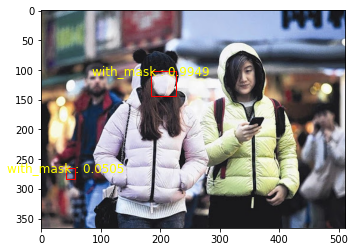

<Figure size 432x288 with 0 Axes>

Target 1 with loaded model


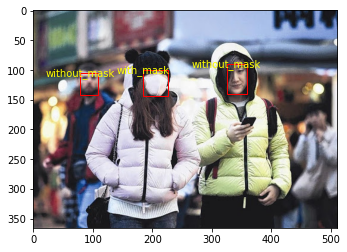

<Figure size 432x288 with 0 Axes>


Predict 2 with loaded model


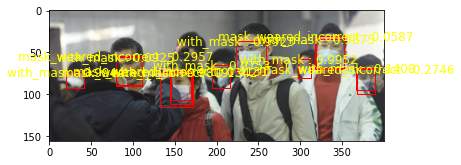

<Figure size 432x288 with 0 Axes>

Target 2 with loaded model


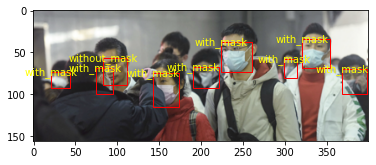

<Figure size 432x288 with 0 Axes>


Predict 3 with loaded model


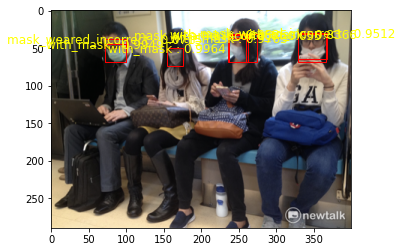

<Figure size 432x288 with 0 Axes>

Target 3 with loaded model


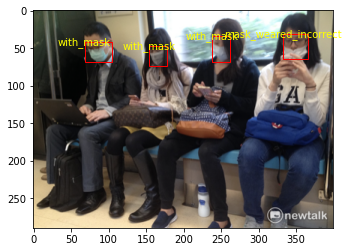

<Figure size 432x288 with 0 Axes>


Predict 4 with loaded model


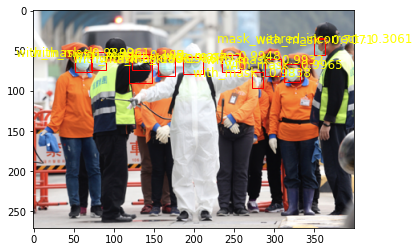

<Figure size 432x288 with 0 Axes>

Target 4 with loaded model


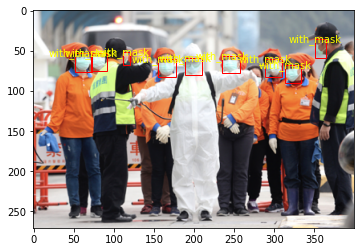

<Figure size 432x288 with 0 Axes>

In [36]:
for i in range(4):
  print("Predict {} with loaded model".format(i+1))
  plot_image(imgs[i], pred2[i])
  print("Target {} with loaded model".format(i+1))
  plot_image(imgs[i], annotations[i], False)
  print()